# Advanced Asset Management

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from matplotlib import pyplot as plt
import random

In [46]:
# LOADING
df_market=pd.read_excel(r"DATA_PROJECT.xlsx", 'RETURNS',usecols='AV', header=0)
df_stocks=pd.read_excel(r"DATA_PROJECT.xlsx", 'RETURNS',usecols='B:AU', header=0)

market = np.array(df_market)
stocks = np.array(df_stocks)
dates = np.array(pd.read_excel(r"DATA_PROJECT.xlsx", 'RETURNS',usecols='A'))

In [3]:
# FORMULAS CALCULATION
def r_mom(r,u):
    res = np.mean(r[u-11:u])
    return res

def s_mom(r,u):
    model = sm.OLS(r[u-35:u],market[u-35:u])
    results = model.fit()
    alpha=results.params[0]
    #coeff = results.params[1:]
    epsilon = results.resid
    res = (alpha+np.sum(epsilon[u-12:u]))/12
    return res

def momentum_score(r,u):
    return (r_mom(r,u)+s_mom(r,u))/2

#m = momentum_score(stocks,65)

def inverse_vol (r):
    vol=np.std(r,axis=0)
    inv_vol = 1/vol
    w = inv_vol/np.sum(inv_vol)
    
    return w

### 1. Simulate the monthly performances of a cluster-based long/short momentum strategy, from August 2008 to March 2022

In [30]:
stocks.shape

(200, 46)

the array *stocks* contains 200 monthly observations of 46 stocks

In [6]:
# STEP 1: Using the full data available, from time 0 up to time t, identity the 2 main
# European stock clusters, through a hierarchical clustering approach.

#features = preprocessing.scale(stocks,axis=0,with_mean=False)
nb_clust=2

in_sample = 35 #31/07/2008

nb_cluster1 =[]
nb_cluster2 = []
date_plot = []
out_sample_plot = []

global_pf = np.zeros((stocks.shape[1],stocks.shape[0]-in_sample,))

In [51]:
my_cluster=sch.linkage(df_stocks, method  = "ward")
my_cluster.shape

(199, 4)

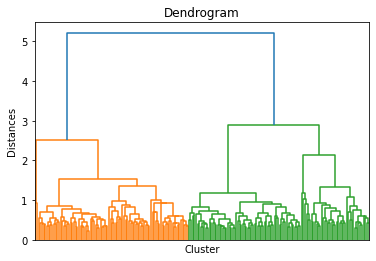

In [145]:
# Plot the dendrogram to visualize the clusters
dendrogram = sch.dendrogram(my_cluster)
plt.title('Dendrogram')
plt.xlabel('Cluster')
plt.ylabel('Distances')
plt.xticks([])
plt.show()

The array *my_cluster* contains the clustering distances in the first two columns, the distance between those two measures in the third, and the number of newly formed clusters in the fourth. We can form clusters through different metrics. 

To show how clusters are made, we can first visualise the case of two stocks.

In [185]:
from sklearn.cluster import AgglomerativeClustering

try_stocks=df_stocks.loc[:,['SOCIETE GENERALE SA','AIRBUS SE']]
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(try_stocks)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0], dtype=int64)

The function *fit_predict* assigns each pair of returns to a cluster. Here we used 2 clusters, that can for example be interpreted as 'risk-on' and 'risk-off' mode.

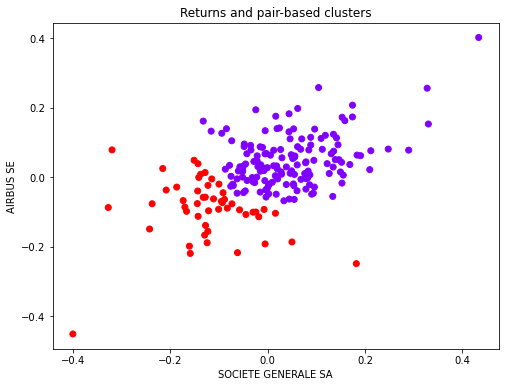

In [232]:
plt.figure(figsize=(8, 6))
plt.scatter(try_stocks.iloc[:,0], try_stocks.iloc[:,1], c=cluster.labels_, cmap='rainbow')
plt.xlabel(try_stocks.columns[0])
plt.ylabel(try_stocks.columns[1])
plt.title('Returns and pair-based clusters')
plt.show()

We can modify the pair to see how the relation changes. However, when we work with a portfolio, we handle more than two stocks. So, even though a two-stock cluster may seem straightforward, a cluster based on an index is not so. 

We now plot the same graph for the same stocks, but considering a cluster based on all index components.

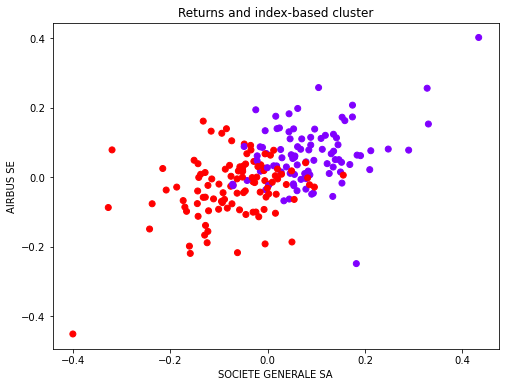

In [279]:
cluster2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster2.fit_predict(stocks)
plt.figure(figsize=(8, 6))
plt.scatter(try_stocks.iloc[:,0], try_stocks.iloc[:,1], c=cluster2.labels_, cmap='rainbow_r')
plt.xlabel(try_stocks.columns[0])
plt.ylabel(try_stocks.columns[1])
plt.title('Returns and index-based cluster')
plt.show()

together:

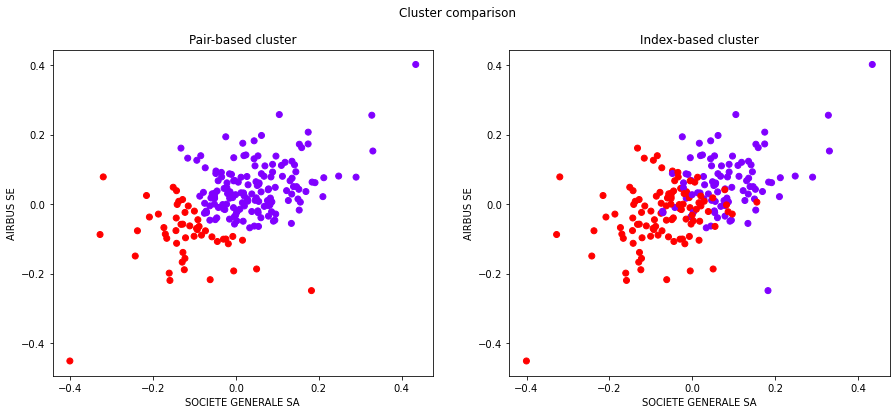

In [284]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(try_stocks.iloc[:,0], try_stocks.iloc[:,1], c=cluster.labels_, cmap='rainbow')
ax2.scatter(try_stocks.iloc[:,0], try_stocks.iloc[:,1], c=cluster2.labels_, cmap='rainbow_r')

fig.suptitle('Cluster comparison')
ax1.set_title('Pair-based cluster')
ax2.set_title('Index-based cluster')

ax1.set_xlabel(try_stocks.columns[0])
ax1.set_ylabel(try_stocks.columns[1])

ax2.set_xlabel(try_stocks.columns[0])
ax2.set_ylabel(try_stocks.columns[1])

plt.show()

So it is now clear that the pair-based cluster seems to be more accurate than the index-based cluster (which is normal).

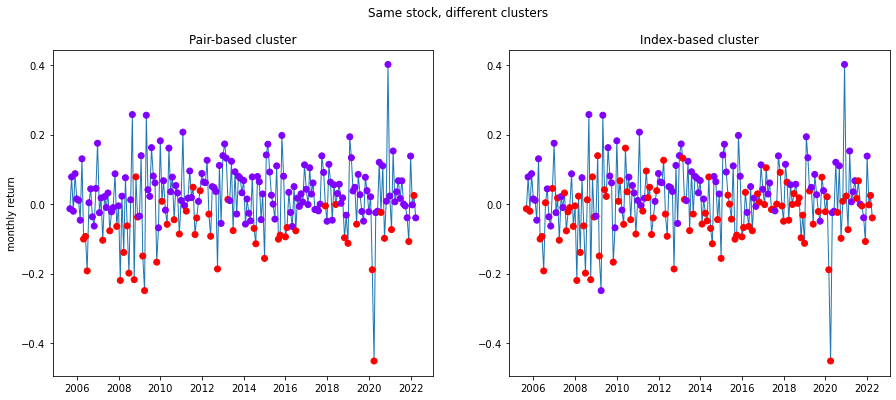

In [285]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(dates, try_stocks.iloc[:,1], c=cluster.labels_, cmap='rainbow', zorder=3)
ax1.plot(dates, try_stocks.iloc[:,1], linewidth=1)

ax2.scatter(dates, try_stocks.iloc[:,1], c=cluster2.labels_, cmap='rainbow_r', zorder=3)
ax2.plot(dates, try_stocks.iloc[:,1], linewidth=1)

fig.suptitle('Same stock, different clusters')

ax1.set_title('Pair-based cluster')
ax2.set_title('Index-based cluster')

ax1.set_ylabel('monthly return')

plt.show()

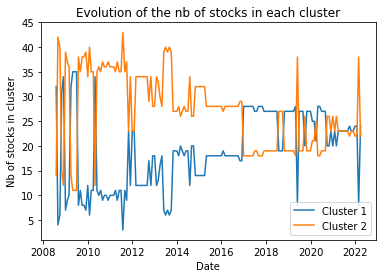

In [6]:
# STEP 2: Within each cluster, rank each stock according to its momentum score
for t in range(in_sample,len(stocks)):
    # DISTANCES
    dist=pdist(stocks[:t+1,:].T,'correlation')
    # LINKAGE
    output = linkage(dist,method='ward')
    # CLUSTERING
    clusters=fcluster(output,nb_clust,criterion='maxclust')
    
    score1 = momentum_score(stocks[:,clusters==1],t) # momentum score within cluster 1
    clust1_rank = score1.argsort() #ranking within cluster1
    
    score2 = momentum_score(stocks[:,clusters==2],t)
    clust2_rank = score2.argsort()
    
    # STEP 3: Build a long/short momentum portfolio within each of the 2 clusters
    #CLUSTER 1
    long1 = np.argwhere(clust1_rank>np.median(clust1_rank))
    long1 = np.reshape(long1,(long1.shape[0],))
    short1 = np.argwhere(clust1_rank<np.median(clust1_rank))
    short1 = np.reshape(short1,(short1.shape[0],))
    
    ret_l1 = stocks[:,long1] 
    # returns of long positions within cluster 1, col 1 = stock n°0, col2 = stock n°3
    # based on long1
    ret_s1 = stocks[:,short1] #returns of short positions within cluster 1
    
    alloc_long1 = inverse_vol(ret_l1)
    alloc_short1 = -inverse_vol(ret_l1)
    
    weight1=np.zeros(stocks[:,clusters==1].shape[1])
    weight1[long1]=alloc_long1
    weight1[short1]=alloc_short1
    
    #CLUSTER 2
    long2 = np.argwhere(clust2_rank>np.median(clust2_rank))
    long2 = np.reshape(long2,(long2.shape[0],))
    short2 = np.argwhere(clust2_rank<np.median(clust2_rank))
    short2 = np.reshape(short2,(short2.shape[0],))
    
    ret_l2 = stocks[:,long2] #returns of long positions within cluster 2
    ret_s2 = stocks[:,short2] #returns of short positions within cluster 2
    
    alloc_long2 = inverse_vol(ret_l2)
    alloc_short2 = -inverse_vol(ret_l2)
    
    weight2=np.zeros(stocks[:,clusters==2].shape[1])
    weight2[long2]=alloc_long2
    weight2[short2]=alloc_short2
    
    # STEP 4: Build the global cluster-based long/short momentum portfolio

    n1 = weight1.shape[0]
    n2 = weight2.shape[0]

    global_pf[:stocks[:,clusters==1].shape[1],t-in_sample]=(n1*weight1)/(n1+n2)
    global_pf[stocks[:,clusters==1].shape[1]:,t-in_sample]=(n2*weight2)/(n1+n2)
    
    nb_cluster1.append(n1)
    nb_cluster2.append(n2)
    
    # STEP 5: Compute the out-of-sample performance at time t+1 
# of the global cluster-based long/short momentum portfolio
    return_out_sample = np.dot(stocks[t+1:,:],global_pf[:,t-in_sample]).T
    out_sample_plot.append(return_out_sample)

    date_plot.append(dates[t])
# Plot historical evolution of the number of stocks in the 2 clusters
plt.plot(date_plot,nb_cluster1,label='Cluster 1')
plt.plot(date_plot,nb_cluster2,label='Cluster 2')
plt.xlabel("Date")
plt.ylabel("Nb of stocks in cluster")
plt.legend(loc='lower right')
plt.title('Evolution of the nb of stocks in each cluster')
plt.show()

In [7]:
# PART TWO – Assess the performance of this cluster-based long/short momentum investment strategy

In [8]:
#STEP 1: Compute the following risk and performance metrics from the simulated track
#record of the investment strategy

ret_strat = np.diag(np.dot(stocks[in_sample+1:,:],global_pf))
cum_ret_strat = (1+ret_strat).cumprod()-1

annual_ret_strat = np.mean(ret_strat)*(stocks[:,in_sample+1:].shape[0]/12)
annual_vol_strat = np.mean(np.dot(np.diag(np.dot(global_pf.T,np.std(stocks[:,in_sample+1:]))),
                                  global_pf))*((stocks[in_sample+1:].shape[0]/12)**0.5)

#CVaR 95%,1mth
CVaR_strat = np.mean(ret_strat[ret_strat<np.quantile(ret_strat,0.05)])*100

# Maximum drawdown
cum_ret_strat = (1+ret_strat).cumprod()
hwm_strat     = np.maximum.accumulate(cum_ret_strat)
dd_strat      = (cum_ret_strat-hwm_strat)/hwm_strat
mdd_strat     = np.amax(-dd_strat)

# Sharpe Ratio 
rf = 0.03/(12) #10Y T-bond is around 0.03
sr_strat =(np.mean(ret_strat)-rf)/np.std(ret_strat)

# CVaR Ratio
CVaR_r_strat = (np.mean(ret_strat)-rf)/CVaR_strat

#Calmar Ratio
calmar_r_strat = (np.mean(ret_strat)-rf)/mdd_strat

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 11.84it/s]


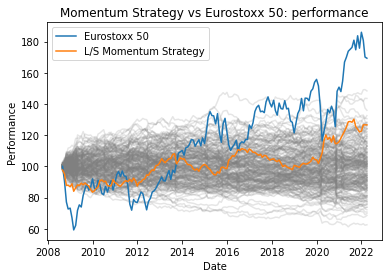

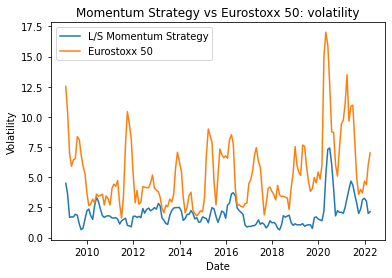

In [9]:
#STEP 2: Check the significancy of these risk and performance statistics against the null
#hypothesis of luck. Comment your results.
n_sim =200

#Test for random signal
signal_pf = np.zeros((stocks.shape[1],stocks.shape[0]-in_sample,))
signal_out_sample_plot = []

stat_out = np.zeros((n_sim,7))
from tqdm import tqdm
for n in tqdm(range(n_sim)):
    for t in range(in_sample,len(stocks)):
    # DISTANCES
        dist=pdist(stocks[:t+1,:].T,'correlation')
    # LINKAGE
        output = linkage(dist,method='ward')
    # CLUSTERING
        clusters=fcluster(output,nb_clust,criterion='maxclust')
    #Generate signals
        signal_cluster1 = [random.choice([-1, 1]) for i in range(stocks[:,clusters==1].shape[1])]
        signal_cluster2 = [random.choice([-1, 1]) for i in range(stocks[:,clusters==2].shape[1])]
    #Long/Short random signal Portfolio construction
        alloc_signal1 = signal_cluster1*inverse_vol(stocks[:,clusters==1])
        alloc_signal2 = signal_cluster2*inverse_vol(stocks[:,clusters==2])
        
        s1 = alloc_signal1.shape[0]
        s2 = alloc_signal2.shape[0]

        signal_pf[:stocks[:,clusters==1].shape[1],t-in_sample]=(s1*alloc_signal1)/(s1+s2)
        signal_pf[stocks[:,clusters==1].shape[1]:,t-in_sample]=(s2*alloc_signal2)/(s1+s2)
    #Out of sample random signal pf returns
        signal_out_sample = np.dot(stocks[t+1:,:],signal_pf[:,t-in_sample]).T
        signal_out_sample_plot.append(signal_out_sample)
    #Statistics
    ret_signal = np.diag(np.dot(stocks[in_sample+1:,:],signal_pf))
    cum_ret_signal = (1+ret_signal).cumprod()-1
    
    annual_ret_signal = np.mean(ret_signal)*(stocks[:,in_sample+1:].shape[0]/12)
    annual_vol_signal = np.mean(np.dot(np.diag(np.dot(signal_pf.T,np.std(stocks[:,in_sample+1:]))),
                                  signal_pf))*((stocks[in_sample+1:].shape[0]/12)**0.5)
    
    plt.plot(date_plot[1:],(cum_ret_signal+1)*100, c='grey', alpha=0.2)
    
    #CVaR 95%,1mth
    CVaR_signal = np.mean(ret_signal[ret_signal<np.quantile(ret_signal,0.05)])*100

    # Maximum drawdown
    cum_ret = (1+ret_signal).cumprod()
    hwm     = np.maximum.accumulate(cum_ret)
    dd      = (cum_ret-hwm)/hwm
    mdd_signal     = np.amax(-dd)

    # Sharpe Ratio 
    sr_signal =(np.mean(ret_signal)-rf)/np.std(ret_signal)
    
    # CVaR Ratio
    CVaR_r_signal = (np.mean(ret_signal)-rf)/CVaR_signal

    #Calmar Ratio
    calmar_r_signal = (np.mean(ret_signal)-rf)/mdd_signal

    stat_out[n,0]=annual_ret_signal
    stat_out[n,1]=annual_vol_signal
    stat_out[n,2]=CVaR_signal
    stat_out[n,3]=mdd_signal
    stat_out[n,4]=sr_signal
    stat_out[n,5]=CVaR_r_signal
    stat_out[n,6]=calmar_r_signal

market_plot=(1+market[in_sample+1:len(stocks)]).cumprod()*100
strat_plot=(cum_ret_strat)*100
date_plot2=date_plot[1:]

plt.plot(date_plot2,market_plot, label="Eurostoxx 50")
plt.plot(date_plot2,strat_plot, label='L/S Momentum Strategy')
plt.title("Momentum Strategy vs Eurostoxx 50: performance")
plt.xlabel("Date")
plt.ylabel("Performance")
plt.legend()
plt.show()

plt.title("Momentum Strategy vs Eurostoxx 50: volatility")
rolling_vol_strat=pd.Series(strat_plot).rolling(6).std()
rolling_vol_market=pd.Series(market_plot).rolling(6).std()
plt.plot(date_plot2, rolling_vol_strat, label='L/S Momentum Strategy')
plt.plot(date_plot2, rolling_vol_market, label="Eurostoxx 50")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [10]:
# Confidence intervals

CVaR_mkt    = np.mean(market[market<np.quantile(market,0.05)])*100
cum_ret_mkt = (1+market).cumprod()
hwm_mkt     = np.maximum.accumulate(cum_ret_mkt)
dd_mkt      = (cum_ret_mkt-hwm_mkt)/hwm_mkt
mdd_mkt     = np.amax(-dd_mkt)
sr_mkt      =(np.mean(market)-rf)/np.std(market)
CVaR_r_mkt  = (np.mean(market)-rf)/CVaR_mkt
calmar_r_mkt= (np.mean(market)-rf)/mdd_mkt

annual_ret_signal_ci=round(np.percentile(stat_out[:,0], (100-95)/2), 4), round(np.percentile(stat_out[:,0], 95 + (100-95)/2), 4)
annual_vol_signal_ci=round(np.percentile(stat_out[:,1], (100-95)/2), 4), round(np.percentile(stat_out[:,1], 95 + (100-95)/2), 4)
CVaR_signal_ci=round(np.percentile(stat_out[:,2], (100-95)/2), 4), round(np.percentile(stat_out[:,2], 95 + (100-95)/2), 4)
mdd_signal_ci=round(np.percentile(stat_out[:,3], (100-95)/2), 4), round(np.percentile(stat_out[:,3], 95 + (100-95)/2), 4)
sr_signal_ci=round(np.percentile(stat_out[:,4], (100-95)/2), 4), round(np.percentile(stat_out[:,4], 95 + (100-95)/2), 4)
CVaR_r_signal_ci=round(np.percentile(stat_out[:,5], (100-95)/2), 4), round(np.percentile(stat_out[:,5], 95 + (100-95)/2), 4)
calmar_r_signal_ci=round(np.percentile(stat_out[:,6], (100-95)/2), 4), round(np.percentile(stat_out[:,6], 95 + (100-95)/2), 4)

print('annual_ret_strat =',round(annual_ret_strat,4), '- annual_ret_signal_ci =',annual_ret_signal_ci)
print('annual_vol_strat =',round(annual_vol_strat,4), '- annual_vol_signal_ci =',annual_vol_signal_ci)
print('CVaR_strat =',round(CVaR_strat,4), '- CVaR_signal_ci =',CVaR_signal_ci)
print('mdd_strat =',round(mdd_strat,4), '- mdd_signal_ci =',mdd_signal_ci)
print('sr_strat =',round(sr_strat,4), '- sr_signal_ci =',sr_signal_ci)
print('CVaR_r_strat =',round(CVaR_r_strat,4), '- CVaR_r_signal_ci =',CVaR_r_signal_ci)
print('calmar_r_strat =',round(calmar_r_strat,4), '- calmar_r_signal_ci =',calmar_r_signal_ci)
print('')
print('annual_ret_mkt =',round(np.mean(market),4))
print('annual_vol_mkt =',round(np.std(market),4))
print('CVaR_mkt =',round(CVaR_mkt,4))
print('mdd_mkt =',round(mdd_mkt,4))
print('sr_mkt =',round(sr_mkt,4))
print('CVaR_r_mkt =',round(CVaR_r_mkt,4))
print('calmar_r_mkt =',round(calmar_r_mkt,4))

annual_ret_strat = 0.0275 - annual_ret_signal_ci = (-0.0296, 0.0268)
annual_vol_strat = 0.0014 - annual_vol_signal_ci = (-0.0001, 0.0002)
CVaR_strat = -4.3494 - CVaR_signal_ci = (-3.441, -1.8575)
mdd_strat = 0.1455 - mdd_signal_ci = (0.0779, 0.2986)
sr_strat = -0.0419 - sr_signal_ci = (-0.3723, -0.0719)
CVaR_r_strat = 0.0002 - CVaR_r_signal_ci = (0.0004, 0.0015)
calmar_r_strat = -0.0059 - calmar_r_signal_ci = (-0.0246, -0.007)

annual_ret_mkt = 0.0044
annual_vol_mkt = 0.05
CVaR_mkt = -11.6643
mdd_mkt = 0.5421
sr_mkt = 0.0374
CVaR_r_mkt = -0.0002
calmar_r_mkt = 0.0034
